In [2]:
# DISTILLBERT TRAINING

import pandas as pd
from transformers import DistilBertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Load the dataset
df = pd.read_csv('/content/Cleaned_Statements_try.csv')

# Map labels to numeric values
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Map the status to labels and drop any rows with NaN values
df['labels'] = df['status'].map(label_map)

# Drop rows with NaN in 'labels'
df.dropna(subset=['labels'], inplace=True)

# Ensure the 'statement' column is of type string
texts = df['statement'].astype(str).tolist()

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Convert the labels to a tensor with the correct shape
labels_tensor = torch.tensor(df['labels'].values, dtype=torch.long)

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create the dataset
dataset = SentimentDataset(inputs['input_ids'], inputs['attention_mask'], labels_tensor)

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/results',  # Directory for storing model checkpoints
    num_train_epochs=16,                          # Number of training epochs
    per_device_train_batch_size=16,              # Batch size for training
    per_device_eval_batch_size=64,               # Batch size for evaluation
    warmup_steps=500,                            # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                           # Strength of weight decay
    logging_dir='/content/drive/MyDrive/results/logs',  # Directory for storing logs
    logging_steps=10,                            # Log every 10 steps
    evaluation_strategy="epoch",                 # Evaluate at the end of each epoch
    save_strategy="epoch",                       # Save checkpoint at the end of each epoch
    save_total_limit=10,                          # Keep only the last 3 checkpoints
    load_best_model_at_end=True,                 # Automatically load the best model at the end
    metric_for_best_model="accuracy",            # Use accuracy to determine the best model
    greater_is_better=True,                      # Higher accuracy is better
    report_to="none",                            # Disable W&B logging (if not using W&B)
)

# Define the metric computation function
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted'),
        'f1': f1_score(labels, preds, average='weighted')
    }

# Load the pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=7)

# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to train
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=compute_metrics       # Compute metrics
)

# Start fine-tuning the model
trainer.train()

# Save the best model and tokenizer explicitly
best_model_dir = '/content/drive/MyDrive/results/best_model1'
model.save_pretrained(best_model_dir)
tokenizer.save_pretrained(best_model_dir)

# --------- Results Block ---------
# After training is complete, display the results
print(f"Training completed in {trainer.state.global_step} steps.")
print(f"Best model saved in: {best_model_dir}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.886200,0.833717,0.716385,0.729682,0.716385,0.710271
2,0.680500,0.609252,0.786921,0.793410,0.786921,0.784980
3,0.362100,0.607828,0.804555,0.816533,0.804555,0.801955
4,0.241600,0.719638,0.800882,0.813438,0.800882,0.800321
5,0.199300,0.743079,0.814107,0.821185,0.814107,0.815237
6,0.088700,0.909036,0.806760,0.806831,0.806760,0.805628
7,0.104500,0.953907,0.808229,0.813727,0.808229,0.808353
8,0.101800,1.053345,0.806760,0.812573,0.806760,0.808032
9,0.004600,1.072785,0.817046,0.821162,0.817046,0.816930
10,0.013100,1.119917,0.817781,0.824774,0.817781,0.816534


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.886200,0.833717,0.716385,0.729682,0.716385,0.710271
2,0.680500,0.609252,0.786921,0.793410,0.786921,0.784980
3,0.362100,0.607828,0.804555,0.816533,0.804555,0.801955
4,0.241600,0.719638,0.800882,0.813438,0.800882,0.800321
5,0.199300,0.743079,0.814107,0.821185,0.814107,0.815237
6,0.088700,0.909036,0.806760,0.806831,0.806760,0.805628
7,0.104500,0.953907,0.808229,0.813727,0.808229,0.808353
8,0.101800,1.053345,0.806760,0.812573,0.806760,0.808032
9,0.004600,1.072785,0.817046,0.821162,0.817046,0.816930
10,0.013100,1.119917,0.817781,0.824774,0.817781,0.816534


Training completed in 5456 steps.
Best model saved in: /content/drive/MyDrive/results/best_model1


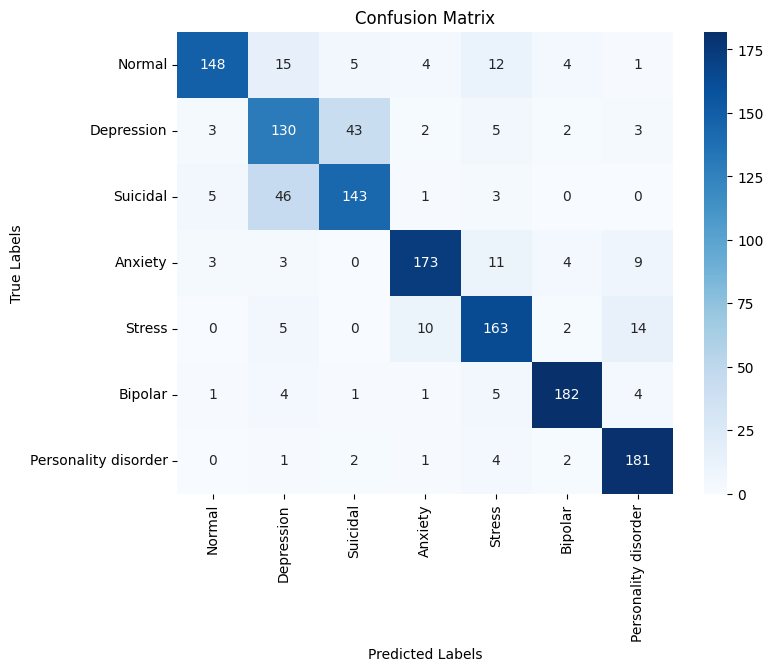

Evaluation Results:
{'eval_loss': 1.1829047203063965, 'eval_model_preparation_time': 0.0015, 'eval_accuracy': 0.8229243203526818, 'eval_precision': 0.8274725423211686, 'eval_recall': 0.8229243203526818, 'eval_specificity': 0.7943686006825939, 'eval_runtime': 21.4113, 'eval_samples_per_second': 63.565, 'eval_steps_per_second': 1.027}


In [3]:
#SEEING RESULTS OF MODEL + CONFUSION MATRIX

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory for your saved model
checkpoint_dir = '/content/drive/MyDrive/results/best_model1'  # Update this with your actual folder path

# Reload the model and tokenizer from the attempt4 folder
model = DistilBertForSequenceClassification.from_pretrained(checkpoint_dir, num_labels=7)
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint_dir)

# Load your dataset (replace with the actual dataset path)
df = pd.read_csv('/content/Cleaned_Statements_try.csv')  # Adjust path as needed

# Map labels to numeric values
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}
df['labels'] = df['status'].map(label_map)
df.dropna(subset=['labels'], inplace=True)

# Ensure the 'statement' column is of type string
texts = df['statement'].astype(str).tolist()

# Tokenize the text data
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Convert the labels to a tensor
labels_tensor = torch.tensor(df['labels'].values, dtype=torch.long)

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create the dataset
dataset = SentimentDataset(inputs['input_ids'], inputs['attention_mask'], labels_tensor)

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Define the metric computation function
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)

    # Calculate accuracy, precision, recall, and specificity
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    # Calculate specificity using confusion matrix
    cm = confusion_matrix(labels, preds)
    tn = cm.diagonal().sum() - cm.sum(axis=1)[0]  # True negatives
    fp = cm.sum(axis=0) - cm.diagonal()  # False positives
    specificity = tn / (tn + fp.sum())  # Specificity formula

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity
    }

# Define TrainingArguments (not needed for evaluation, but kept for consistency)
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/results',  # Output directory
    per_device_eval_batch_size=64,
    report_to="none",  # Disable W&B logging
)

# Create the Trainer with the model, args, and datasets
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Evaluate the model
evaluation_results = trainer.evaluate()

# Print the evaluation results
print("Evaluation Results:")
print(evaluation_results)

# Optionally, save the results to a file
with open(f"{checkpoint_dir}/evaluation_results.txt", "w") as f:
    for key, value in evaluation_results.items():
        f.write(f"{key}: {value}\n")

In [4]:
#LOADING MODEL

from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/results/best_model1')
tokenizer = DistilBertTokenizer.from_pretrained('/content/drive/MyDrive/results/best_model1')

# Check model architecture
print(model)

# Check tokenizer
print(tokenizer)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
# CODE TO MAKE NEW PREDICTIONS

import torch
from torch.nn.functional import softmax

# Define the label map (labels to numeric values)
label_map = {
    'Normal': 0,
    'Depression': 1,
    'Suicidal': 2,
    'Anxiety': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Reverse the label map to map numeric IDs back to labels
reversed_label_map = {v: k for k, v in label_map.items()}

# Define a function to make predictions with confidence levels
def predict_statement(statement):
    # Check if the input statement is non-empty and has a reasonable length
    if not statement or len(statement.strip()) == 0:
        raise ValueError("Input statement is empty or only contains whitespace.")

    # Tokenize the new statement
    try:
        inputs = tokenizer(
            statement,
            padding=True,
            truncation=True,
            return_tensors='pt'
        )
    except Exception as e:
        raise ValueError(f"Error during tokenization: {e}")

    # Ensure the model is in evaluation mode
    model.eval()

    # Push the input through the model to get predictions
    try:
        with torch.no_grad():
            outputs = model(**inputs)
    except Exception as e:
        raise ValueError(f"Error during model inference: {e}")

    # Get the logits and convert them to probabilities
    logits = outputs.logits
    probabilities = softmax(logits, dim=-1).squeeze()

    # Get the predicted class and its confidence
    predicted_class_id = torch.argmax(probabilities).item()
    confidence = probabilities[predicted_class_id].item()

    # Return the predicted status and confidence level using the reversed label map
    return reversed_label_map[predicted_class_id], confidence

# Example usage
new_statement = "Feeling sad and the days feel long while my thoughts begin to get heavy"
predicted_status, confidence_level = predict_statement(new_statement)
print(f"The predicted mental health status is: {predicted_status}")
print(f"Confidence level: {confidence_level:.2f}")

The predicted mental health status is: Depression
Confidence level: 0.99


In [10]:
# MAKING NEW PREDICTIONS

new_statement = "One day I feel good the next day I feel sad and bored and feeling are different."
predicted_status, confidence_level = predict_statement(new_statement)
print(f"The predicted mental health status is: {predicted_status}")
print(f"Confidence level: {confidence_level:.2f}")

The predicted mental health status is: Depression
Confidence level: 1.00
